# Spaceship Titanic - Complete Pipeline

**Competition:** Spaceship Titanic (Kaggle)  
**Problem:** Binary Classification (Transported: True/False)  
**Metric:** Accuracy  
**Data:** ~8700 train / ~4300 test / 14 features  
**Strategy:** Feature Engineering + LightGBM + XGBoost + CatBoost Ensemble

## 1. Configuration & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
import optuna
from scipy.stats import rankdata
import warnings
import gc
import os

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
sns.set_style('whitegrid')

SEED = 42
N_FOLDS = 10
TARGET = 'Transported'

def seed_everything(seed=SEED):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything()

print('Setup complete.')

Setup complete.


C:\Users\Amaury\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Data Loading

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_sub = pd.read_csv('../data/sample_submission.csv')

print(f'Train shape: {train.shape}')
print(f'Test shape:  {test.shape}')
print(f'Submission:  {sample_sub.shape}')
print(f'\nTarget distribution:')
print(train[TARGET].value_counts(normalize=True))
train.head()

Train shape: (8693, 14)
Test shape:  (4277, 13)
Submission:  (4277, 2)

Target distribution:
Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## 3. EDA - Exploratory Data Analysis

In [3]:
print('=== DATA INFO ===')
print(f'\nColumns ({len(train.columns)}):')
for col in train.columns:
    dtype = train[col].dtype
    nunique = train[col].nunique()
    null_pct = train[col].isnull().mean() * 100
    print(f'  {col:20s} | {str(dtype):10s} | {nunique:6d} unique | {null_pct:5.2f}% missing')

=== DATA INFO ===

Columns (14):
  PassengerId          | str        |   8693 unique |  0.00% missing
  HomePlanet           | str        |      3 unique |  2.31% missing
  CryoSleep            | object     |      2 unique |  2.50% missing
  Cabin                | str        |   6560 unique |  2.29% missing
  Destination          | str        |      3 unique |  2.09% missing
  Age                  | float64    |     80 unique |  2.06% missing
  VIP                  | object     |      2 unique |  2.34% missing
  RoomService          | float64    |   1273 unique |  2.08% missing
  FoodCourt            | float64    |   1507 unique |  2.11% missing
  ShoppingMall         | float64    |   1115 unique |  2.39% missing
  Spa                  | float64    |   1327 unique |  2.11% missing
  VRDeck               | float64    |   1306 unique |  2.16% missing
  Name                 | str        |   8473 unique |  2.30% missing
  Transported          | bool       |      2 unique |  0.00% missing


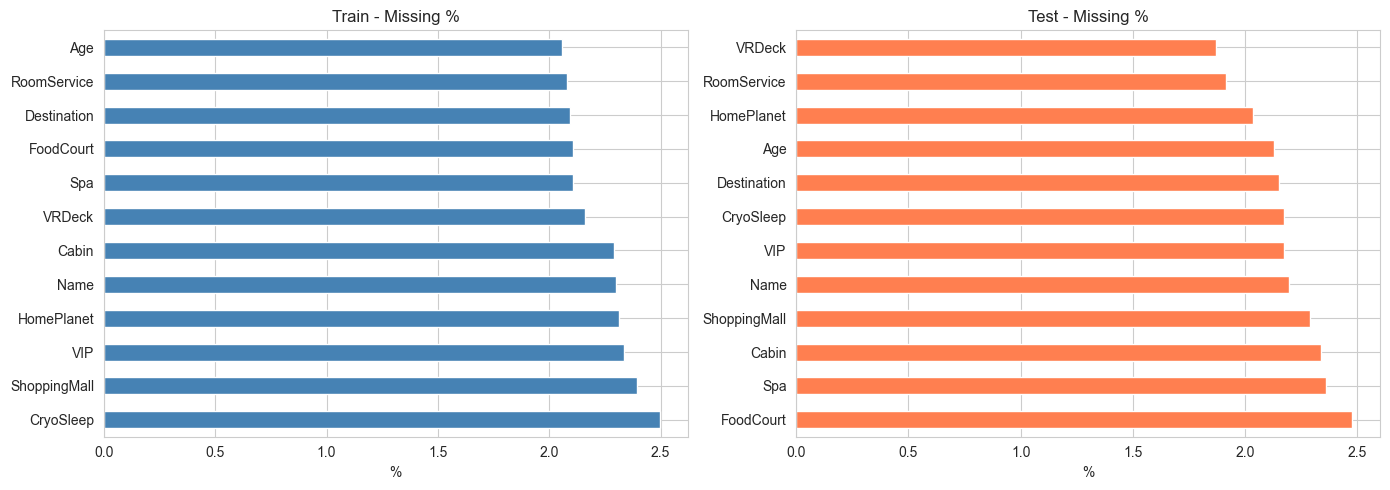

In [4]:
# Missing values comparison train vs test
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train_miss = train.isnull().mean().sort_values(ascending=False) * 100
test_miss = test.isnull().mean().sort_values(ascending=False) * 100

train_miss[train_miss > 0].plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Train - Missing %')
axes[0].set_xlabel('%')

test_miss[test_miss > 0].plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('Test - Missing %')
axes[1].set_xlabel('%')

plt.tight_layout()
plt.show()

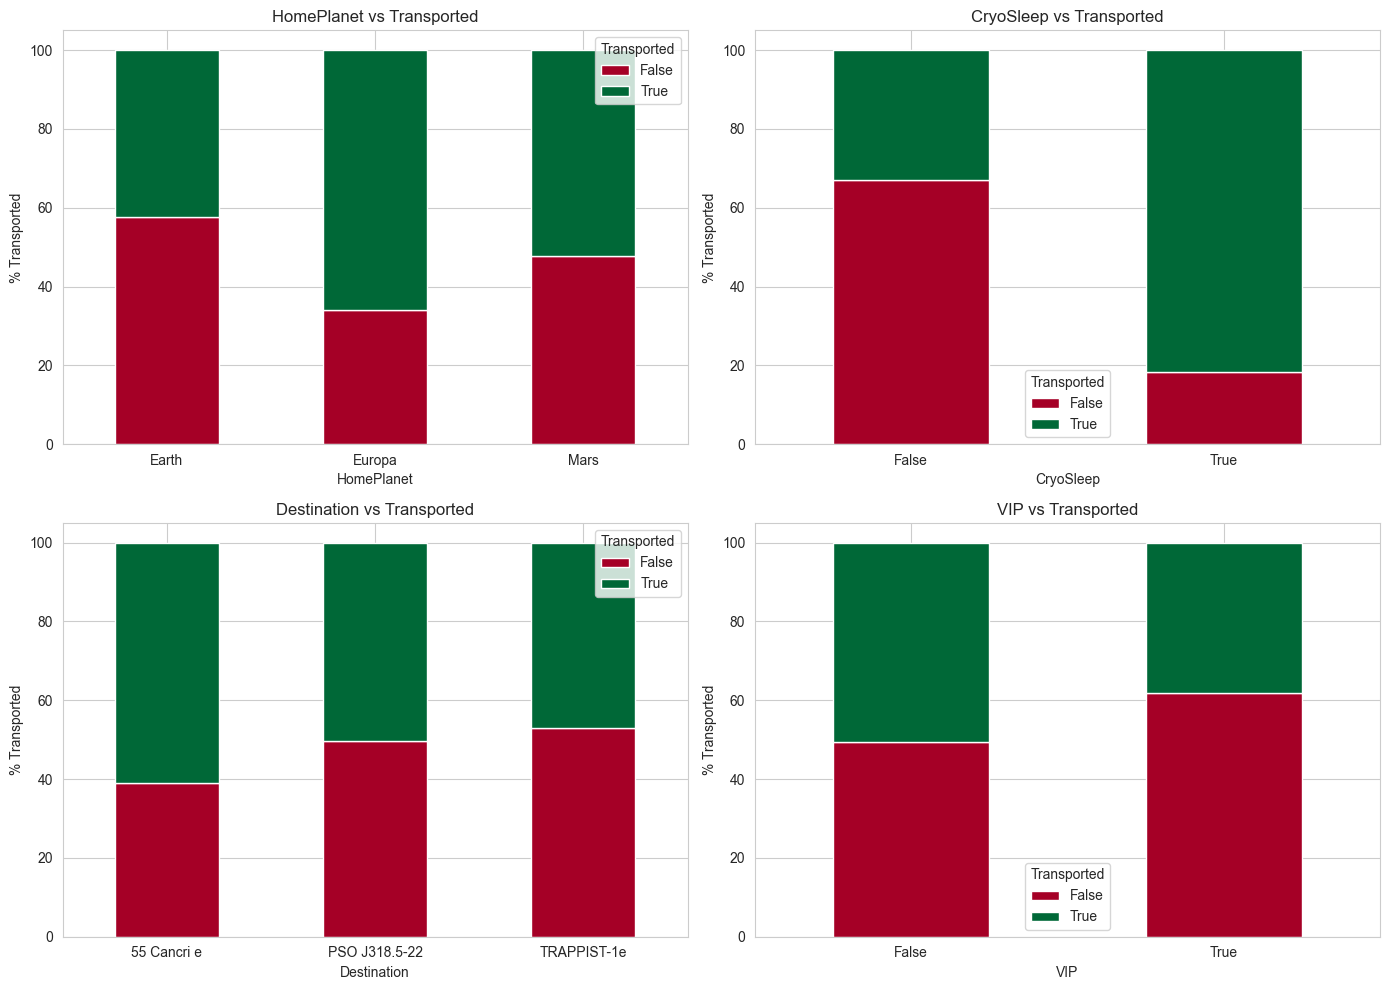

In [5]:
# Target vs categorical features
cat_cols_eda = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for ax, col in zip(axes.flatten(), cat_cols_eda):
    ct = pd.crosstab(train[col], train[TARGET], normalize='index') * 100
    ct.plot(kind='bar', stacked=True, ax=ax, colormap='RdYlGn')
    ax.set_title(f'{col} vs Transported')
    ax.set_ylabel('% Transported')
    ax.legend(title='Transported')
    ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

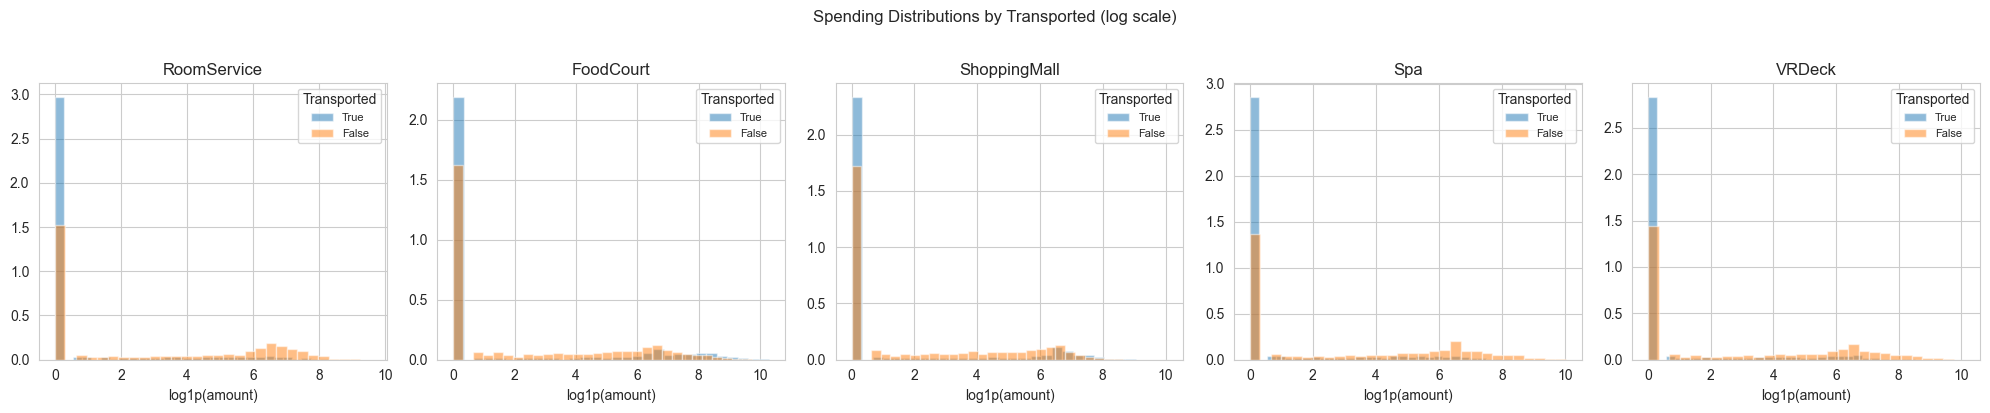

In [6]:
# Spending columns distribution by Transported
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for ax, col in zip(axes, spend_cols):
    for transported in [True, False]:
        subset = train[train[TARGET] == transported][col].dropna()
        # Log transform for better visualization
        subset_log = np.log1p(subset)
        ax.hist(subset_log, bins=30, alpha=0.5, label=str(transported), density=True)
    ax.set_title(col)
    ax.legend(title='Transported', fontsize=8)
    ax.set_xlabel('log1p(amount)')

plt.suptitle('Spending Distributions by Transported (log scale)', y=1.02)
plt.tight_layout()
plt.show()

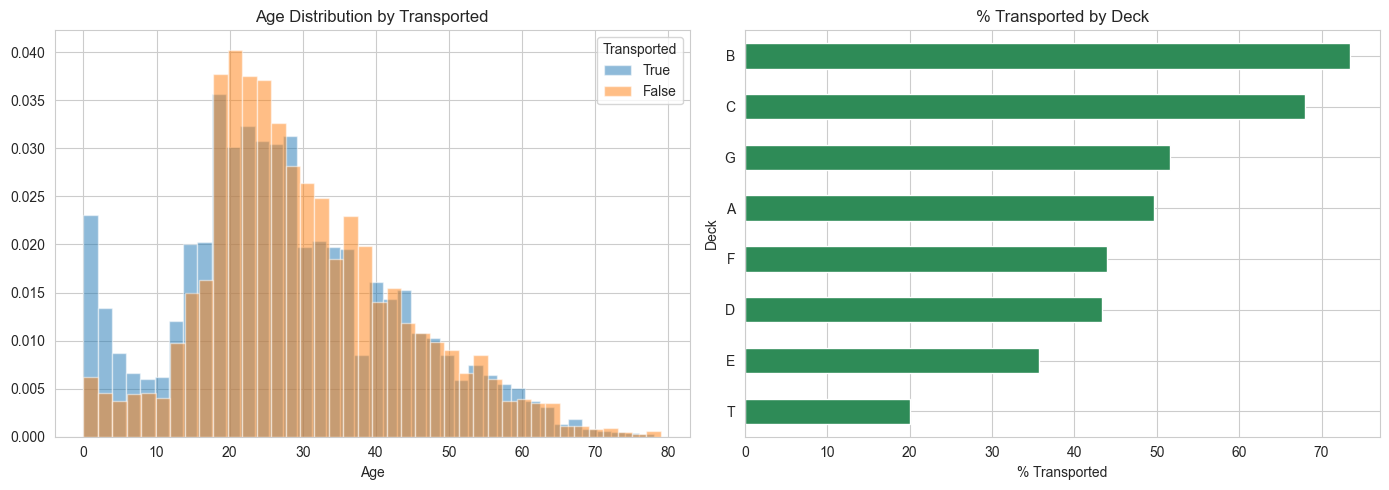

In [7]:
# Age distribution by Transported
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for transported in [True, False]:
    subset = train[train[TARGET] == transported]['Age'].dropna()
    axes[0].hist(subset, bins=40, alpha=0.5, label=str(transported), density=True)
axes[0].set_title('Age Distribution by Transported')
axes[0].legend(title='Transported')
axes[0].set_xlabel('Age')

# Cabin Deck extraction for quick look
train_temp = train.copy()
train_temp['Deck'] = train_temp['Cabin'].str.split('/').str[0]
ct = pd.crosstab(train_temp['Deck'], train_temp[TARGET], normalize='index') * 100
ct[True].sort_values().plot(kind='barh', ax=axes[1], color='seagreen')
axes[1].set_title('% Transported by Deck')
axes[1].set_xlabel('% Transported')

plt.tight_layout()
plt.show()
del train_temp

In [8]:
# Key EDA insights
print('=== KEY EDA INSIGHTS ===')
print()
print('1. CryoSleep is the STRONGEST predictor (~80% transported if True)')
print('2. Europa passengers more likely transported than Earth/Mars')
print('3. CryoSleep passengers have 0 spending (logical: they are asleep)')
print('4. Younger passengers (<18) slightly more likely transported')
print('5. Cabin Deck B & C have highest transport rates')
print('6. VIP passengers LESS likely transported')
print('7. Higher spending generally correlates with NOT transported')
print('8. PassengerId encodes group structure (XXXX_YY = group_member)')
print('9. ~2% missing values across most columns - manageable')
print('10. Target is well balanced (~50/50)')

=== KEY EDA INSIGHTS ===

1. CryoSleep is the STRONGEST predictor (~80% transported if True)
2. Europa passengers more likely transported than Earth/Mars
3. CryoSleep passengers have 0 spending (logical: they are asleep)
4. Younger passengers (<18) slightly more likely transported
5. Cabin Deck B & C have highest transport rates
6. VIP passengers LESS likely transported
7. Higher spending generally correlates with NOT transported
8. PassengerId encodes group structure (XXXX_YY = group_member)
9. ~2% missing values across most columns - manageable
10. Target is well balanced (~50/50)


## 4. Feature Engineering

In [9]:
# Combine train+test for consistent feature engineering
train['is_train'] = 1
test['is_train'] = 0
test[TARGET] = np.nan

df = pd.concat([train, test], axis=0, ignore_index=True)
print(f'Combined shape: {df.shape}')

Combined shape: (12970, 15)


In [10]:
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

def feature_engineering(df):
    """Complete feature engineering pipeline."""
    
    # =========================================================
    # 4.1 - PassengerId decomposition
    # =========================================================
    df['Group'] = df['PassengerId'].str.split('_').str[0].astype(int)
    df['MemberNum'] = df['PassengerId'].str.split('_').str[1].astype(int)
    df['GroupSize'] = df.groupby('Group')['PassengerId'].transform('count')
    df['IsAlone'] = (df['GroupSize'] == 1).astype(int)
    
    # =========================================================
    # 4.2 - Cabin decomposition
    # =========================================================
    df['Deck'] = df['Cabin'].str.split('/').str[0]
    df['CabinNum'] = df['Cabin'].str.split('/').str[1].astype(float)
    df['Side'] = df['Cabin'].str.split('/').str[2]
    
    # =========================================================
    # 4.3 - Name features
    # =========================================================
    df['Surname'] = df['Name'].str.split().str[-1]
    df['FamilySize'] = df.groupby('Surname')['PassengerId'].transform('count')
    # Handle NaN surnames
    df.loc[df['Surname'].isna(), 'FamilySize'] = 1
    
    # =========================================================
    # 4.4 - Spending features
    # =========================================================
    df['TotalSpend'] = df[spend_cols].sum(axis=1)
    df['NoSpend'] = (df['TotalSpend'] == 0).astype(int)
    df['NumServicesUsed'] = (df[spend_cols] > 0).sum(axis=1)
    
    # Luxury vs basic spending
    df['LuxurySpend'] = df['Spa'] + df['VRDeck'] + df['RoomService']
    df['BasicSpend'] = df['FoodCourt'] + df['ShoppingMall']
    
    # Spending ratios (avoid division by zero)
    df['LuxuryRatio'] = df['LuxurySpend'] / (df['TotalSpend'] + 1)
    df['BasicRatio'] = df['BasicSpend'] / (df['TotalSpend'] + 1)
    
    # Max single spending category
    df['MaxSpend'] = df[spend_cols].max(axis=1)
    df['MaxSpendCategory'] = df[spend_cols].idxmax(axis=1)
    
    # Log transforms of spending
    for col in spend_cols:
        df[f'{col}_log'] = np.log1p(df[col])
    df['TotalSpend_log'] = np.log1p(df['TotalSpend'])
    
    # =========================================================
    # 4.5 - Boolean features
    # =========================================================
    df['CryoSleep'] = df['CryoSleep'].map({True: 1, False: 0, 'True': 1, 'False': 0})
    df['VIP'] = df['VIP'].map({True: 1, False: 0, 'True': 1, 'False': 0})
    
    # =========================================================
    # 4.6 - Age features
    # =========================================================
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 5, 12, 18, 30, 50, 80], 
                            labels=[0, 1, 2, 3, 4, 5]).astype(float)
    df['IsChild'] = (df['Age'] < 18).astype(float)
    df['IsElder'] = (df['Age'] >= 50).astype(float)
    
    # =========================================================
    # 4.7 - Interaction features
    # =========================================================
    df['CryoSleep_NoSpend'] = ((df['CryoSleep'] == 1) & (df['TotalSpend'] == 0)).astype(int)
    df['Age_TotalSpend'] = df['Age'] * df['TotalSpend_log']
    
    # =========================================================
    # 4.8 - Group-level features (inspired by titanicv2)
    # =========================================================
    # Average spending per group
    df['GroupSpend_mean'] = df.groupby('Group')['TotalSpend'].transform('mean')
    df['GroupSpend_max'] = df.groupby('Group')['TotalSpend'].transform('max')
    df['GroupAge_mean'] = df.groupby('Group')['Age'].transform('mean')
    
    # Cabin density
    df['CabinNum_rounded'] = (df['CabinNum'] // 10).astype(float)
    
    # =========================================================
    # 4.9 - Encode categoricals
    # =========================================================
    label_cols = ['HomePlanet', 'Destination', 'Deck', 'Side', 'MaxSpendCategory']
    label_encoders = {}
    for col in label_cols:
        le = LabelEncoder()
        df[col + '_le'] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
    
    # Frequency encodings
    for col in ['HomePlanet', 'Destination', 'Deck', 'Side', 'Surname']:
        freq = df[col].value_counts(normalize=True)
        df[col + '_freq'] = df[col].map(freq)
    
    return df, label_encoders

df, label_encoders = feature_engineering(df)
print(f'Features after engineering: {df.shape[1]} columns')

Features after engineering: 58 columns


In [11]:
# =========================================================
# 4.10 - Smart imputation (after feature engineering)
# =========================================================

# CryoSleep passengers must have 0 spending
for col in spend_cols:
    mask = (df['CryoSleep'] == 1) & (df[col].isna())
    df.loc[mask, col] = 0

# Passengers with 0 total spend might be CryoSleep
mask = (df['CryoSleep'].isna()) & (df['TotalSpend'] == 0)
df.loc[mask, 'CryoSleep'] = 1
mask = (df['CryoSleep'].isna()) & (df['TotalSpend'] > 0)
df.loc[mask, 'CryoSleep'] = 0

# Fill remaining numericals with median
num_cols_fill = df.select_dtypes(include=[np.number]).columns
for col in num_cols_fill:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

# Fill remaining categoricals with mode
cat_cols_fill = df.select_dtypes(include=['object']).columns
for col in cat_cols_fill:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])

print(f'Remaining nulls: {df.isnull().sum().sum()}')

Remaining nulls: 0


In [12]:
# =========================================================
# 4.11 - Group Survival Features (key trick from titanicv2)
# =========================================================

# Only use train data for group survival to avoid leakage
train_mask = df['is_train'] == 1

# Group survival rate (leave-one-out to avoid leakage within train)
train_df = df[train_mask].copy()

# For groups with >1 member: compute transported rate of OTHER members
group_sum = train_df.groupby('Group')[TARGET].transform('sum')
group_count = train_df.groupby('Group')[TARGET].transform('count')

# Leave-one-out: (sum - self) / (count - 1), safe division
denom = (group_count - 1).replace(0, np.nan)
train_df['GroupSurvival_loo'] = (group_sum - train_df[TARGET]) / denom
train_df['GroupSurvival_loo'] = train_df['GroupSurvival_loo'].fillna(0.5)  # no info for solo passengers

# For test: use full group transported rate from train
group_rate = train_df.groupby('Group')[TARGET].mean().to_dict()

test_df = df[~train_mask].copy()
test_df['GroupSurvival_loo'] = test_df['Group'].map(group_rate)
test_df['GroupSurvival_loo'] = test_df['GroupSurvival_loo'].fillna(0.5)

df = pd.concat([train_df, test_df], axis=0).sort_index()

# Same for surname (family survival)
train_df = df[train_mask].copy()
fam_sum = train_df.groupby('Surname')[TARGET].transform('sum')
fam_count = train_df.groupby('Surname')[TARGET].transform('count')
fam_denom = (fam_count - 1).replace(0, np.nan)
train_df['FamilySurvival_loo'] = (fam_sum - train_df[TARGET]) / fam_denom
train_df['FamilySurvival_loo'] = train_df['FamilySurvival_loo'].fillna(0.5)

fam_rate = train_df.groupby('Surname')[TARGET].mean().to_dict()
test_df = df[~train_mask].copy()
test_df['FamilySurvival_loo'] = test_df['Surname'].map(fam_rate)
test_df['FamilySurvival_loo'] = test_df['FamilySurvival_loo'].fillna(0.5)

df = pd.concat([train_df, test_df], axis=0).sort_index()

print('Group survival features added.')
print(f'GroupSurvival_loo stats: mean={df["GroupSurvival_loo"].mean():.3f}')
print(f'FamilySurvival_loo stats: mean={df["FamilySurvival_loo"].mean():.3f}')

Group survival features added.
GroupSurvival_loo stats: mean=0.520
FamilySurvival_loo stats: mean=0.497


In [13]:
# Define final features
drop_cols = ['PassengerId', 'Name', 'Cabin', 'Surname', 'is_train', TARGET,
             'HomePlanet', 'Destination', 'Deck', 'Side', 'MaxSpendCategory']

features = [c for c in df.columns if c not in drop_cols]
print(f'Number of features: {len(features)}')
print(f'\nFeatures:')
for i, f in enumerate(sorted(features)):
    print(f'  {i+1:2d}. {f}')

Number of features: 49

Features:
   1. Age
   2. AgeGroup
   3. Age_TotalSpend
   4. BasicRatio
   5. BasicSpend
   6. CabinNum
   7. CabinNum_rounded
   8. CryoSleep
   9. CryoSleep_NoSpend
  10. Deck_freq
  11. Deck_le
  12. Destination_freq
  13. Destination_le
  14. FamilySize
  15. FamilySurvival_loo
  16. FoodCourt
  17. FoodCourt_log
  18. Group
  19. GroupAge_mean
  20. GroupSize
  21. GroupSpend_max
  22. GroupSpend_mean
  23. GroupSurvival_loo
  24. HomePlanet_freq
  25. HomePlanet_le
  26. IsAlone
  27. IsChild
  28. IsElder
  29. LuxuryRatio
  30. LuxurySpend
  31. MaxSpend
  32. MaxSpendCategory_le
  33. MemberNum
  34. NoSpend
  35. NumServicesUsed
  36. RoomService
  37. RoomService_log
  38. ShoppingMall
  39. ShoppingMall_log
  40. Side_freq
  41. Side_le
  42. Spa
  43. Spa_log
  44. Surname_freq
  45. TotalSpend
  46. TotalSpend_log
  47. VIP
  48. VRDeck
  49. VRDeck_log


In [14]:
# Split back to train/test
train_df = df[df['is_train'] == 1].copy()
test_df = df[df['is_train'] == 0].copy()

X = train_df[features].values
y = train_df[TARGET].values.astype(int)
X_test = test_df[features].values

print(f'X: {X.shape}, y: {y.shape}, X_test: {X_test.shape}')
print(f'Target: {np.mean(y):.4f} (should be ~0.50)')

X: (8693, 49), y: (8693,), X_test: (4277, 49)
Target: 0.5036 (should be ~0.50)


## 5. Modeling - LightGBM

In [15]:
lgb_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.03,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'n_estimators': 5000,
    'verbose': -1,
    'n_jobs': -1,
    'random_state': SEED,
}

oof_lgb = np.zeros(len(X))
test_lgb = np.zeros(len(X_test))
fi_lgb = np.zeros(len(features))

kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    
    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(200), lgb.log_evaluation(500)]
    )
    
    oof_lgb[val_idx] = model.predict_proba(X_val)[:, 1]
    test_lgb += model.predict_proba(X_test)[:, 1] / N_FOLDS
    fi_lgb += model.feature_importances_ / N_FOLDS
    
    fold_acc = accuracy_score(y_val, (oof_lgb[val_idx] > 0.5).astype(int))
    print(f'Fold {fold+1}/{N_FOLDS} - Accuracy: {fold_acc:.5f}')

lgb_acc = accuracy_score(y, (oof_lgb > 0.5).astype(int))
print(f'\nLightGBM CV Accuracy: {lgb_acc:.5f}')

Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.378042
Early stopping, best iteration is:
[364]	valid_0's binary_logloss: 0.374713
Fold 1/10 - Accuracy: 0.81724
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.358133
Early stopping, best iteration is:
[447]	valid_0's binary_logloss: 0.356292
Fold 2/10 - Accuracy: 0.82759
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.340363
Early stopping, best iteration is:
[444]	valid_0's binary_logloss: 0.338587
Fold 3/10 - Accuracy: 0.83563
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.410935
Early stopping, best iteration is:
[530]	valid_0's binary_logloss: 0.408249


Fold 4/10 - Accuracy: 0.80207
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.360207
Early stopping, best iteration is:
[365]	valid_0's binary_logloss: 0.357946
Fold 5/10 - Accuracy: 0.82739
Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[229]	valid_0's binary_logloss: 0.384438
Fold 6/10 - Accuracy: 0.82969
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.35579


Early stopping, best iteration is:
[621]	valid_0's binary_logloss: 0.353906
Fold 7/10 - Accuracy: 0.82394
Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[296]	valid_0's binary_logloss: 0.36592
Fold 8/10 - Accuracy: 0.80552
Training until validation scores don't improve for 200 rounds


[500]	valid_0's binary_logloss: 0.379055
Early stopping, best iteration is:
[330]	valid_0's binary_logloss: 0.375498
Fold 9/10 - Accuracy: 0.81128
Training until validation scores don't improve for 200 rounds


Early stopping, best iteration is:
[258]	valid_0's binary_logloss: 0.394019
Fold 10/10 - Accuracy: 0.81243

LightGBM CV Accuracy: 0.81928


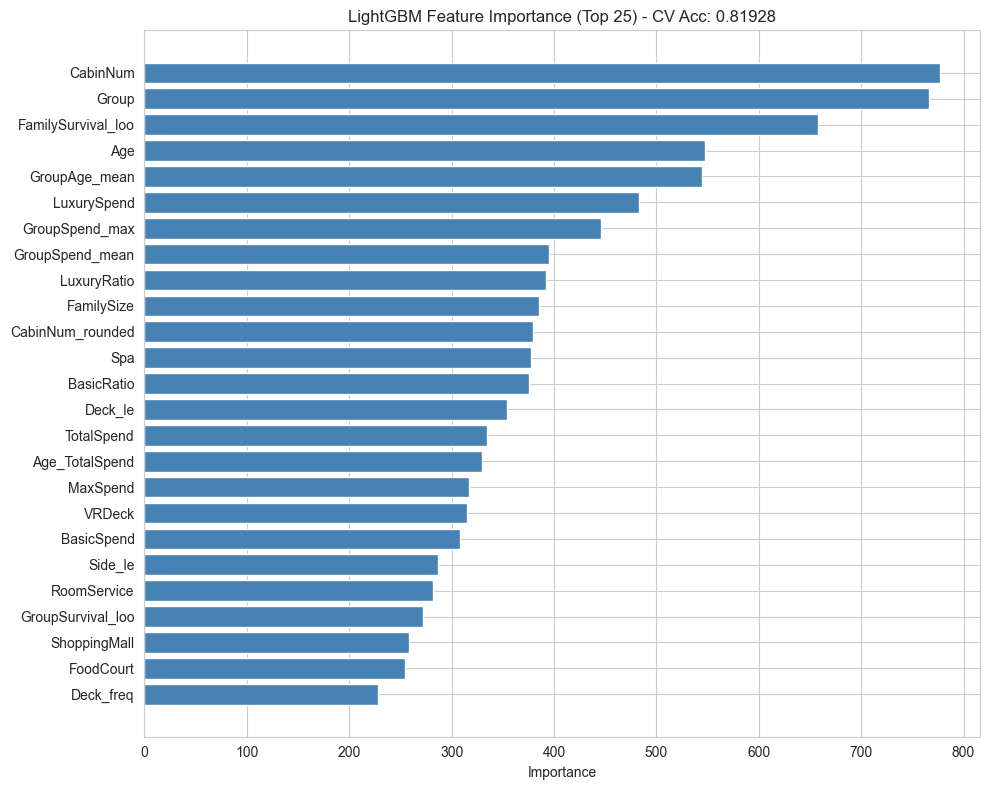

In [16]:
# Feature importance
fi_df = pd.DataFrame({'feature': features, 'importance': fi_lgb})
fi_df = fi_df.sort_values('importance', ascending=True).tail(25)

plt.figure(figsize=(10, 8))
plt.barh(fi_df['feature'], fi_df['importance'], color='steelblue')
plt.title(f'LightGBM Feature Importance (Top 25) - CV Acc: {lgb_acc:.5f}')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## 6. Modeling - XGBoost

In [17]:
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 6,
    'learning_rate': 0.03,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'n_estimators': 5000,
    'early_stopping_rounds': 200,
    'tree_method': 'hist',
    'random_state': SEED,
    'verbosity': 0,
}

oof_xgb = np.zeros(len(X))
test_xgb = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    
    model = xgb.XGBClassifier(**xgb_params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=500
    )
    
    oof_xgb[val_idx] = model.predict_proba(X_val)[:, 1]
    test_xgb += model.predict_proba(X_test)[:, 1] / N_FOLDS
    
    fold_acc = accuracy_score(y_val, (oof_xgb[val_idx] > 0.5).astype(int))
    print(f'Fold {fold+1}/{N_FOLDS} - Accuracy: {fold_acc:.5f}')

xgb_acc = accuracy_score(y, (oof_xgb > 0.5).astype(int))
print(f'\nXGBoost CV Accuracy: {xgb_acc:.5f}')

[0]	validation_0-logloss:0.67981


[500]	validation_0-logloss:0.38161


[579]	validation_0-logloss:0.38154


Fold 1/10 - Accuracy: 0.80690
[0]	validation_0-logloss:0.67905


[500]	validation_0-logloss:0.35650


[569]	validation_0-logloss:0.35576


Fold 2/10 - Accuracy: 0.83333
[0]	validation_0-logloss:0.67965


[500]	validation_0-logloss:0.34736


[730]	validation_0-logloss:0.34899


Fold 3/10 - Accuracy: 0.83908
[0]	validation_0-logloss:0.68025


[500]	validation_0-logloss:0.41049


[754]	validation_0-logloss:0.41292


Fold 4/10 - Accuracy: 0.80552
[0]	validation_0-logloss:0.67930


[500]	validation_0-logloss:0.35259


[825]	validation_0-logloss:0.35559


Fold 5/10 - Accuracy: 0.82854
[0]	validation_0-logloss:0.67955


[500]	validation_0-logloss:0.37907


[557]	validation_0-logloss:0.37881


Fold 6/10 - Accuracy: 0.82278
[0]	validation_0-logloss:0.67971


[500]	validation_0-logloss:0.34968


[805]	validation_0-logloss:0.35286


Fold 7/10 - Accuracy: 0.82509
[0]	validation_0-logloss:0.67898


[500]	validation_0-logloss:0.36489


[593]	validation_0-logloss:0.36516


Fold 8/10 - Accuracy: 0.80898
[0]	validation_0-logloss:0.67955


[500]	validation_0-logloss:0.37790


[907]	validation_0-logloss:0.38042


Fold 9/10 - Accuracy: 0.81243
[0]	validation_0-logloss:0.68016


[500]	validation_0-logloss:0.39441


[758]	validation_0-logloss:0.40000


Fold 10/10 - Accuracy: 0.80092

XGBoost CV Accuracy: 0.81836


## 7. Modeling - CatBoost

In [18]:
oof_cb = np.zeros(len(X))
test_cb = np.zeros(len(X_test))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_tr, X_val = X[train_idx], X[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    
    model = CatBoostClassifier(
        iterations=5000,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=3.0,
        subsample=0.8,
        colsample_bylevel=0.8,
        min_data_in_leaf=20,
        random_seed=SEED,
        verbose=500,
        early_stopping_rounds=200,
        task_type='CPU',
    )
    
    model.fit(
        X_tr, y_tr,
        eval_set=(X_val, y_val),
    )
    
    oof_cb[val_idx] = model.predict_proba(X_val)[:, 1]
    test_cb += model.predict_proba(X_test)[:, 1] / N_FOLDS
    
    fold_acc = accuracy_score(y_val, (oof_cb[val_idx] > 0.5).astype(int))
    print(f'Fold {fold+1}/{N_FOLDS} - Accuracy: {fold_acc:.5f}')

cb_acc = accuracy_score(y, (oof_cb > 0.5).astype(int))
print(f'\nCatBoost CV Accuracy: {cb_acc:.5f}')

0:	learn: 0.6760524	test: 0.6763498	best: 0.6763498 (0)	total: 147ms	remaining: 12m 13s


500:	learn: 0.2937030	test: 0.3803472	best: 0.3802971 (495)	total: 1.51s	remaining: 13.6s


1000:	learn: 0.2235203	test: 0.3729058	best: 0.3728521 (839)	total: 2.86s	remaining: 11.4s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.371511204
bestIteration = 1219

Shrink model to first 1220 iterations.
Fold 1/10 - Accuracy: 0.81034
0:	learn: 0.6759851	test: 0.6754700	best: 0.6754700 (0)	total: 3.78ms	remaining: 18.9s


500:	learn: 0.2950955	test: 0.3505150	best: 0.3505118 (499)	total: 1.38s	remaining: 12.4s


1000:	learn: 0.2219648	test: 0.3423090	best: 0.3420612 (980)	total: 2.73s	remaining: 10.9s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3416843116
bestIteration = 1171

Shrink model to first 1172 iterations.
Fold 2/10 - Accuracy: 0.84828
0:	learn: 0.6759370	test: 0.6748348	best: 0.6748348 (0)	total: 4.91ms	remaining: 24.5s


500:	learn: 0.2943602	test: 0.3558437	best: 0.3558116 (495)	total: 1.35s	remaining: 12.2s


1000:	learn: 0.2217996	test: 0.3469497	best: 0.3468292 (998)	total: 2.69s	remaining: 10.8s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.345442491
bestIteration = 1186

Shrink model to first 1187 iterations.
Fold 3/10 - Accuracy: 0.83218
0:	learn: 0.6759069	test: 0.6775940	best: 0.6775940 (0)	total: 3.63ms	remaining: 18.1s


500:	learn: 0.2899117	test: 0.4079513	best: 0.4079513 (500)	total: 1.33s	remaining: 12s


1000:	learn: 0.2187004	test: 0.4029370	best: 0.4025656 (962)	total: 2.65s	remaining: 10.6s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4025656364
bestIteration = 962

Shrink model to first 963 iterations.
Fold 4/10 - Accuracy: 0.81588
0:	learn: 0.6743822	test: 0.6746138	best: 0.6746138 (0)	total: 2.84ms	remaining: 14.2s


500:	learn: 0.2954364	test: 0.3551415	best: 0.3551415 (500)	total: 1.37s	remaining: 12.3s


1000:	learn: 0.2229489	test: 0.3468110	best: 0.3464232 (983)	total: 2.72s	remaining: 10.9s


1500:	learn: 0.1765977	test: 0.3422551	best: 0.3419218 (1415)	total: 4.07s	remaining: 9.49s


2000:	learn: 0.1431606	test: 0.3433030	best: 0.3409521 (1868)	total: 5.44s	remaining: 8.16s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3409520677
bestIteration = 1868

Shrink model to first 1869 iterations.


Fold 5/10 - Accuracy: 0.84120
0:	learn: 0.6730106	test: 0.6738204	best: 0.6738204 (0)	total: 3.9ms	remaining: 19.5s


500:	learn: 0.2925827	test: 0.3888762	best: 0.3888762 (500)	total: 1.35s	remaining: 12.1s


1000:	learn: 0.2203200	test: 0.3823850	best: 0.3812846 (934)	total: 2.67s	remaining: 10.7s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3812845588
bestIteration = 934

Shrink model to first 935 iterations.
Fold 6/10 - Accuracy: 0.82163
0:	learn: 0.6735962	test: 0.6724952	best: 0.6724952 (0)	total: 3.31ms	remaining: 16.5s


500:	learn: 0.2973471	test: 0.3534883	best: 0.3534026 (495)	total: 1.36s	remaining: 12.2s


1000:	learn: 0.2251969	test: 0.3451410	best: 0.3451410 (1000)	total: 2.72s	remaining: 10.9s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3448541234
bestIteration = 1027

Shrink model to first 1028 iterations.
Fold 7/10 - Accuracy: 0.83774
0:	learn: 0.6759931	test: 0.6760851	best: 0.6760851 (0)	total: 4.58ms	remaining: 22.9s


500:	learn: 0.2937401	test: 0.3640747	best: 0.3640102 (499)	total: 1.34s	remaining: 12.1s


1000:	learn: 0.2227474	test: 0.3593215	best: 0.3591576 (996)	total: 2.69s	remaining: 10.8s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3571054564
bestIteration = 1248

Shrink model to first 1249 iterations.
Fold 8/10 - Accuracy: 0.82854
0:	learn: 0.6762255	test: 0.6764034	best: 0.6764034 (0)	total: 3.04ms	remaining: 15.2s


500:	learn: 0.2935463	test: 0.3818859	best: 0.3818283 (487)	total: 1.36s	remaining: 12.2s


1000:	learn: 0.2201036	test: 0.3760100	best: 0.3756713 (943)	total: 2.7s	remaining: 10.8s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3756713292
bestIteration = 943

Shrink model to first 944 iterations.
Fold 9/10 - Accuracy: 0.80783
0:	learn: 0.6729990	test: 0.6751176	best: 0.6751176 (0)	total: 3.34ms	remaining: 16.7s


500:	learn: 0.2898452	test: 0.3942644	best: 0.3942644 (500)	total: 1.37s	remaining: 12.3s


1000:	learn: 0.2194119	test: 0.3877970	best: 0.3872005 (929)	total: 2.71s	remaining: 10.8s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3863453383
bestIteration = 1141

Shrink model to first 1142 iterations.
Fold 10/10 - Accuracy: 0.80783

CatBoost CV Accuracy: 0.82515


## 8. Ensemble

In [19]:
print('=== Individual Model Scores ===')
print(f'LightGBM: {lgb_acc:.5f}')
print(f'XGBoost:  {xgb_acc:.5f}')
print(f'CatBoost: {cb_acc:.5f}')
print()

# Simple average ensemble
oof_avg = (oof_lgb + oof_xgb + oof_cb) / 3
avg_acc = accuracy_score(y, (oof_avg > 0.5).astype(int))
print(f'Simple Average Ensemble: {avg_acc:.5f}')

# Weighted ensemble - find optimal weights via grid search
best_acc = 0
best_w = (1/3, 1/3, 1/3)

for w1 in np.arange(0.1, 0.8, 0.05):
    for w2 in np.arange(0.1, 0.8 - w1, 0.05):
        w3 = 1 - w1 - w2
        if w3 < 0.05:
            continue
        oof_w = w1 * oof_lgb + w2 * oof_xgb + w3 * oof_cb
        acc = accuracy_score(y, (oof_w > 0.5).astype(int))
        if acc > best_acc:
            best_acc = acc
            best_w = (w1, w2, w3)

print(f'\nOptimal Weighted Ensemble: {best_acc:.5f}')
print(f'Weights: LGB={best_w[0]:.2f}, XGB={best_w[1]:.2f}, CB={best_w[2]:.2f}')

=== Individual Model Scores ===
LightGBM: 0.81928
XGBoost:  0.81836
CatBoost: 0.82515

Simple Average Ensemble: 0.82434

Optimal Weighted Ensemble: 0.82653
Weights: LGB=0.35, XGB=0.10, CB=0.55


In [20]:
# Rank-based ensemble (more robust to score scale differences)
oof_rank = (
    rankdata(oof_lgb) + rankdata(oof_xgb) + rankdata(oof_cb)
) / 3
rank_threshold = np.median(oof_rank)  # since ~50/50 split
rank_acc = accuracy_score(y, (oof_rank > rank_threshold).astype(int))
print(f'Rank Ensemble: {rank_acc:.5f}')

# Majority voting
votes = (
    (oof_lgb > 0.5).astype(int) + 
    (oof_xgb > 0.5).astype(int) + 
    (oof_cb > 0.5).astype(int)
)
vote_acc = accuracy_score(y, (votes >= 2).astype(int))
print(f'Majority Voting: {vote_acc:.5f}')

Rank Ensemble: 0.82480
Majority Voting: 0.82170


In [21]:
# Select best ensemble method
ensemble_scores = {
    'Simple Average': avg_acc,
    'Weighted Average': best_acc,
    'Rank Ensemble': rank_acc,
    'Majority Voting': vote_acc,
}

best_method = max(ensemble_scores, key=ensemble_scores.get)
print(f'\nBest Ensemble Method: {best_method} ({ensemble_scores[best_method]:.5f})')

# Generate final test predictions with best method
if best_method == 'Simple Average':
    final_proba = (test_lgb + test_xgb + test_cb) / 3
elif best_method == 'Weighted Average':
    final_proba = best_w[0] * test_lgb + best_w[1] * test_xgb + best_w[2] * test_cb
elif best_method == 'Rank Ensemble':
    final_proba = (rankdata(test_lgb) + rankdata(test_xgb) + rankdata(test_cb)) / 3
    # Use same relative threshold
elif best_method == 'Majority Voting':
    final_votes = (
        (test_lgb > 0.5).astype(int) + 
        (test_xgb > 0.5).astype(int) + 
        (test_cb > 0.5).astype(int)
    )

# Convert to binary predictions
if best_method == 'Majority Voting':
    final_preds = (final_votes >= 2)
elif best_method == 'Rank Ensemble':
    final_preds = (final_proba > np.median(final_proba))
else:
    final_preds = (final_proba > 0.5)

print(f'\nTest predictions: {final_preds.sum()} True / {len(final_preds) - final_preds.sum()} False')
print(f'Ratio: {final_preds.mean():.4f} (should be ~0.50)')


Best Ensemble Method: Weighted Average (0.82653)

Test predictions: 2171 True / 2106 False
Ratio: 0.5076 (should be ~0.50)


## 9. Submission

In [22]:
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'].values,
    'Transported': final_preds
})

# Ensure boolean format matches sample_submission
submission['Transported'] = submission['Transported'].astype(bool)

submission.to_csv('../submissions/submission.csv', index=False)

print('Submission saved!')
print(f'Shape: {submission.shape}')
print(f'\nDistribution:')
print(submission['Transported'].value_counts(normalize=True))
print(f'\nFirst rows:')
submission.head(10)

Submission saved!
Shape: (4277, 2)

Distribution:
Transported
True     0.507599
False    0.492401
Name: proportion, dtype: float64

First rows:


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
5,0027_01,True
6,0029_01,True
7,0032_01,True
8,0032_02,True
9,0033_01,True


In [23]:
# Validation: compare with sample submission format
assert submission.shape[0] == sample_sub.shape[0], 'Row count mismatch!'
assert list(submission.columns) == list(sample_sub.columns), 'Column mismatch!'
assert submission['Transported'].dtype == bool, 'Type mismatch!'
print('Submission format validated!')

Submission format validated!


## 10. Summary & Next Steps

In [24]:
print('=' * 60)
print('          SPACESHIP TITANIC - PIPELINE SUMMARY')
print('=' * 60)
print(f'\nFeatures engineered: {len(features)}')
print(f'CV Folds: {N_FOLDS}')
print(f'\n--- Model Scores (CV Accuracy) ---')
print(f'  LightGBM:  {lgb_acc:.5f}')
print(f'  XGBoost:   {xgb_acc:.5f}')
print(f'  CatBoost:  {cb_acc:.5f}')
print(f'\n--- Ensemble Scores ---')
for method, score in sorted(ensemble_scores.items(), key=lambda x: -x[1]):
    marker = ' <-- BEST' if method == best_method else ''
    print(f'  {method:20s}: {score:.5f}{marker}')
print(f'\n--- Submission ---')
print(f'  File: ../submissions/submission.csv')
print(f'  Rows: {submission.shape[0]}')
print(f'  True ratio: {submission["Transported"].mean():.4f}')
print(f'\n--- Next Steps ---')
print('  1. Submit to Kaggle and check LB score')
print('  2. Hyperparameter tuning with Optuna')
print('  3. Add more interaction features')
print('  4. Try neural network (TabNet, MLP)')
print('  5. Pseudo-labeling with confident predictions')
print('  6. Target encoding with proper CV')
print('=' * 60)

          SPACESHIP TITANIC - PIPELINE SUMMARY

Features engineered: 49
CV Folds: 10

--- Model Scores (CV Accuracy) ---
  LightGBM:  0.81928
  XGBoost:   0.81836
  CatBoost:  0.82515

--- Ensemble Scores ---
  Weighted Average    : 0.82653 <-- BEST
  Rank Ensemble       : 0.82480
  Simple Average      : 0.82434
  Majority Voting     : 0.82170

--- Submission ---
  File: ../submissions/submission.csv
  Rows: 4277
  True ratio: 0.5076

--- Next Steps ---
  1. Submit to Kaggle and check LB score
  2. Hyperparameter tuning with Optuna
  3. Add more interaction features
  4. Try neural network (TabNet, MLP)
  5. Pseudo-labeling with confident predictions
  6. Target encoding with proper CV
